<a href="https://colab.research.google.com/github/Dforouzanfar/Algorithms_for_Massive_Data/blob/master/MBA_Apriori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis
# Project for the **Algorithms for massive data course**

Danial Forouzanfar  
November 2024

# 0. preliminary setup

## 0.1. Setup PySpark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, size
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

## 0.2. Importing the required libraries

In [ ]:
from google.colab import files
import zipfile
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import nltk
import re

## 0.3. Getting the data

In [ ]:
os.environ['KAGGLE_USERNAME'] = "**"
os.environ['KAGGLE_KEY'] = "**"

In [ ]:
data_path = Path("data/")

# If the data folder doesn't exist, download it and prepare it...
if not data_path.is_dir():
  data_path.mkdir(parents=True, exist_ok=True)

  # Download dataset
  os.chdir(data_path)
  !kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024

  os.chdir("/content/")
  with zipfile.ZipFile("/content/data/1-3m-linkedin-jobs-and-skills-2024.zip", "r") as zip_ref:
      print("Unzipping")
      zip_ref.extractall(data_path)

  file_paths = [
    "/content/data/1-3m-linkedin-jobs-and-skills-2024.zip",
    "/content/data/linkedin_job_postings.csv",
    "/content/data/job_summary.csv"
    ]

  # Remove unnecessary files
  for file_path in file_paths:
    os.remove(file_path)

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
 99% 1.86G/1.88G [00:24<00:00, 73.8MB/s]
100% 1.88G/1.88G [00:24<00:00, 83.1MB/s]
Unzipping


In [ ]:
job_skills = spark.read.csv('/content/data/job_skills.csv', header=True, inferSchema=True, sep=",")
job_skills = job_skills.dropna()

# 1. Some Initial Information and Data Preprocessing

In [ ]:
# The total number of rows
job_skills.count()

1294374

In [ ]:
# Schema
job_skills.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)



In [ ]:
# The content of 2 first rows
job_skills.show(2)

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
+--------------------+--------------------+
only showing top 2 rows



In [ ]:
skill_column = job_skills.select('job_skills')

sample = skill_column.sample(False, 0.1, seed=42)

In [ ]:
# N. of baskets
sample.count()

128798

In [ ]:
myrdd = sample.rdd.map(lambda x: x[0])

In [ ]:
def preprocess(data):
  #lower the text and split the skills
  skills_list = data.lower().split(',')

  # Remove punctuation
  skills_list = [re.sub(r'[^\w\s]', '', skill) for skill in skills_list]

  # Remove whitespaces
  skills_list = [skill.strip() for skill in skills_list]

  return skills_list

In [ ]:
myrdd = myrdd.map(preprocess)

# 2. Apriori algorithm implementation

In [ ]:
def MBA_Apriori(rdd,
                p=0.02,
                max_size=3):

  # threshold
  threshold = int(rdd.count() * p)

  # Hashing
  skill_index = (rdd.flatMap(lambda line: line) # The lambda function takes each line and returns it directly
                    .distinct()                 # removes duplicate elements
                    .zipWithIndex()             # pairs each element of the RDD with a unique index
                    .collectAsMap())            # collects the elements of the RDD into a dictionary
  rdd = rdd.map(lambda basket: [skill_index[skill] for skill in basket])

  results, candidates = [], []

  c_size = 1
  while c_size <= max_size:

    # Filtering
    if c_size == 1:
      # Frequent singletons
      frequent_singletons = (rdd.flatMap(lambda basket: [(skill, 1) for skill in basket])
                                .reduceByKey(lambda x1, x2: x1 + x2) # groups the pairs by the skill key and sums the values (1s) for each skill.
                                .filter(lambda x: x[1] > threshold)) # Filters the results to keep only those skills whose count exceeds the specified threshold.

      print(f"We have {frequent_singletons.count()} frequent singletons")

      results += [(tuple([x[0]]), x[1]) for x in frequent_singletons.collect()]
      frequent_singletons = frequent_singletons.map(lambda x:x[0]) # Skill

      # Candidates for next pass
      candidates = (frequent_singletons.cartesian(frequent_singletons)          # Cartesian product of items from frequent_singletons. ['A', 'B', 'C'] -> [(A,A),(A,B),(A,C),(B,A),(B,B),(B,C),(C,A),(C,B),(C,C)]
                                       .filter(lambda x: len(set(x)) == len(x)) # Filters out pairs that contain the same item twice
                                       .map(lambda x: tuple(sorted(x)))         # turning pairs like (A, B) and (B, A) into (A, B).
                                       .distinct()                              # Removes the duplicate pairs
                                       .collect())
    else:
      # Frequent itemsets
      frequent_itemsets = (rdd.flatMap(lambda basket: [(tuple(candidate), 1) for candidate in candidates if set(candidate).issubset(set(basket))])
                              .reduceByKey(lambda x1, x2: x1 + x2)
                              .filter(lambda x: x[1] > threshold))

      print(f"We have {frequent_itemsets.count()} frequent {c_size}-size itemsets")

      results += frequent_itemsets.collect()
      frequent_itemsets = frequent_itemsets.map(lambda x: x[0])

      # Compute candidates for the next iteration
      candidates = (frequent_itemsets.cartesian(frequent_itemsets)
                                     .map(lambda tuples: {item for t in tuples for item in t})
                                     .filter(lambda x: len(x) == c_size+1)
                                     .map(lambda x: tuple(sorted(x)))
                                     .distinct()
                                     .collect())

    c_size += 1

  index_skill = {value:key for key, value in skill_index.items()}
  return [(index_skill[x[0]], x[1]) if type(x[0]) == int else (tuple([index_skill[element] for element in x[0]]), x[1]) for x in results] # With index_skill we change the numbers (Indexes) to the texts (skills)

In [ ]:
# This would take about 13 minutes to run
MBA = MBA_Apriori(rdd=myrdd)

We have 81 frequent singletons
We have 67 frequent 2-size itemsets
We have 25 frequent 3-size itemsets


In [ ]:
# Most frequent itemsets
MBA_sorted = sorted(MBA, key=lambda x: x[1], reverse=True)

# Convert the list of tuples into a DataFrame
mydf = pd.DataFrame(MBA_sorted, columns=['Skills', 'Count'])

# Remove the parentheses by converting each tuple to a comma-separated string
mydf['Skills'] = mydf['Skills'].apply(lambda x: ', '.join(map(str, x)))

mydf.head(10)

,Skills,Count
0,communication,36743
1,customer service,27406
2,teamwork,22616
3,communication skills,19488
4,leadership,18311
5,problem solving,14793
6,time management,14170
7,"teamwork, communication",13815
8,"customer service, communication",13731
9,attention to detail,13267


In [ ]:
# Using a dictionary to simulate dynamic variable names
variables = {}

for i in range(1, 4):
    variables[f'top_5_pairs_of_{i}_skills'] = [item for item in MBA_sorted if isinstance(item[0], tuple) and len(item[0]) == i][:5]

In [ ]:
top_singletons = variables[f'top_5_pairs_of_1_skills']
top_pairs = variables[f'top_5_pairs_of_2_skills']
top_triples = variables[f'top_5_pairs_of_3_skills']

# 3. Results

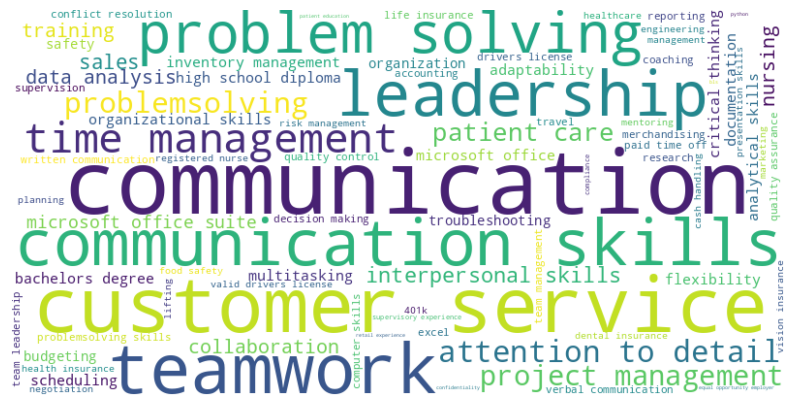

In [ ]:
from wordcloud import WordCloud

top_singleton_freq = {item[0]: frequency for item, frequency in MBA_sorted if len(item) == 1}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_singleton_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<font size=4> In the cell below, the `itemset` can have three values:  
* top_singletons
* top_pairs
* top_triples

If you want to see the top singletons you need to set `itemset = 'top_singletons` and so on. </font>

In [ ]:
itemset = 'top_triples' # possible values: 'top_singletons', 'top_pairs', 'top_triples'

match itemset:
  case 'top_singletons':
    skill = [item[0][0] for item in top_singletons]
    count = [item[1] for item in top_singletons]
  case 'top_pairs':
    skill = [item[0] for item in top_pairs]
    count = [item[1] for item in top_pairs]
  case 'top_triples':
    skill = [item[0] for item in top_triples]
    count = [item[1] for item in top_triples]

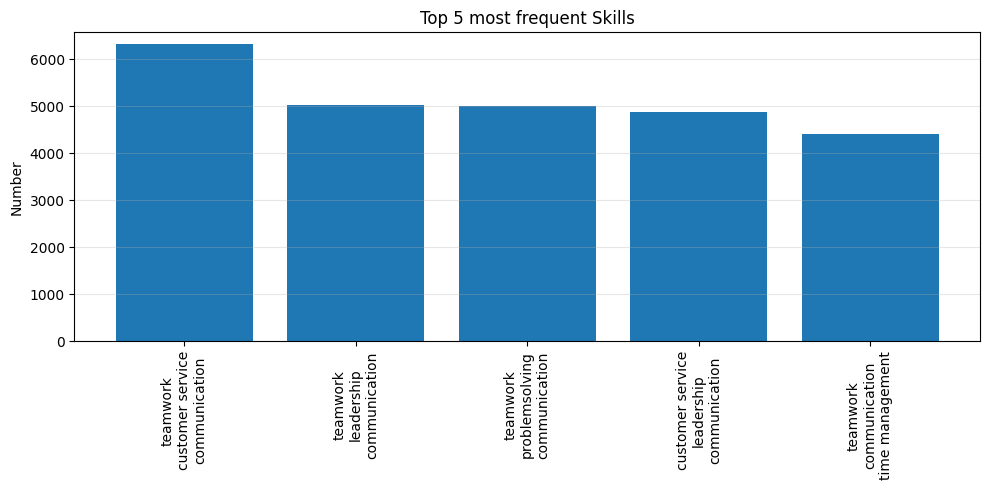

In [ ]:
plt.figure(figsize=(10, 5))
bars = plt.bar(['\n'.join(item) if type(item) == tuple else item for item in skill], count)
plt.title('Top 5 most frequent Skills')
plt.ylabel('Number')
plt.xticks(rotation=90)
plt.ylim(0, max(count)+250)
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()